# Kalman and H Infinity Filters Applied to Motor State Estimation

In this notebook, I follow example 12.2 from *Optimal Estimation* by Dan Simon. I use python to simulate fake data from a motor and then compare state estimation performance of 1) a Kalman filter, 2) a H $\infty$ filter, and 3) a Mixed Kalman H $\infty$ filter. 

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

## Model Background

In this example, the state consists of a motor's angular position $\phi$ and its derivative $\dot{\phi}$. The only measurement is the angular position $\phi$. The table below explains the remaining parameters of the system.

| Parameter | Description |
|-----------|-------------|
|  $J$      | motor inertia |
| $c$       | a motor torque constant that related applied voltage to generate torque |
| $B$       | coefficient of viscous friction |
| $u$       | applied voltage |
| $w$       | unmodeled torque that can be considered as noise |

Below are variables and equation of motion are represented using `sympy`.

In [2]:
t = sympy.symbols('t')  # time
phi = sympy.symbols('phi', cls=sympy.Function)  # angle of the motor
J = sympy.symbols('J', positive=True)
c = sympy.symbols('c', positive=True)
w = sympy.symbols('w')
B = sympy.symbols('B')
u = sympy.symbols('u')
x = sympy.Matrix([[phi(t)], [phi(t).diff(t)]])

eq = sympy.Eq(J * phi(t).diff(t,2) + B * phi(t).diff(t),  c * u + w) 

print("Dynamic System:")
display(eq)

Dynamic System:


Eq(B*Derivative(phi(t), t) + J*Derivative(phi(t), (t, 2)), c*u + w)

### State Space

The state space equations will be the following:

<center>
$
\begin{bmatrix} \dot{\phi} \\ \ddot{\phi} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 0 & -\frac{B}{J} \end{bmatrix} 
\begin{bmatrix} \phi \\ \dot{\phi} \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{c}{J} \end{bmatrix} u +
\begin{bmatrix} 0 \\ \frac{1}{J} \end{bmatrix} w
$
</center>

Put another way, the system can be described by

<center>
$\dot{x} = A x + B_u u + B_w w $
</center>

where 

$ A = \begin{bmatrix} 0 & 1 \\ 0 & -\frac{B}{J} \end{bmatrix} $

$ B_u = \begin{bmatrix} 0 \\ \frac{c}{J} \end{bmatrix} $ 

$ B_w = \begin{bmatrix} 0 \\ \frac{1}{J} \end{bmatrix} $


The measurement of the motor angle has some noise $v_k$. The measurement equation is shown below.

\begin{equation}
    y_k = \begin{bmatrix} 1 &  0 \end{bmatrix} x_k + v_k
\end{equation}

We can use `sympy` to create these matricies and then substitute in parameters as a dictionary.

In [3]:
A = sympy.Matrix([[0, 1], [0, -B / J]])
B_u = sympy.Matrix([[0], [c / J]])
B_w = sympy.Matrix([[0], [1 / J]])

params = {c: 5, J: 10, B: 40}

A_np = np.array(A.subs(params)).astype(np.float64)
B_u_np = np.array(B_u.subs(params)).astype(np.float64)
B_w_np = np.array(B_w.subs(params)).astype(np.float64)
H = np.array([[1, 0]])

### Discretize

Here we discretize using Euler method.

In [4]:
timestep = 0.01
A_d = np.identity(2) + timestep * A_np
Bd_u = timestep * B_u_np
Bd_w = timestep * B_w_np

## Defining the Noise Matricies 

| Noise | Standard Deviation | Unit |
| ------|--------------------|------|
| Torque Noise $w_k$| 2                  | Nm |
| Measurement Noise $v_k$ | 0.2           | deg|


Based on the noise standard deviations listed above, we calculate the Q and R. 

Note that since there is a $B_w$ matrix for the noise in the process, we can account for this by lumping it into the $Q$ matrix.

\begin{equation}
Q = B_w \sigma_w B_w^T
\end{equation}

In [5]:
vk_standard_deviation = 0.2 * np.pi / 180
torque_noise_standard_deviation = 2

R = np.array([[vk_standard_deviation ** 2]])
Q = B_w_np * (torque_noise_standard_deviation ** 2) * B_w_np.T

## Kalman Filter 

I'm including Kalman filter in this comparison as our baseline algorithm. For many state estimation algorithms, Kalman filter is the first approach. So it will be interesting to see benchmark the H $\infty$  relative to the Kalman filter.

Below I recap the Kalman Filter equations.

\begin{equation}
    \begin{split}
        x_k & = F_{k-1} x_{k-1} + G_u u_{k-1} + G_w w_{k-1} \\
        y_k & = H_k x_k + v_k \\
        w_k & ~ (0, Q_k) \\
        v_k & ~ (0, R_k) \\
    \end{split}
\end{equation}

For the given system above, we have the Kalman filter equations below. Note that I use the Joseph form for the error covariance for the updated estimate. This is more numerically stable and ensures that the covariance matrix is positive definite.

\begin{align}
    \text{Prediction: } & \hat{x}_{k(-)} = \phi_{k-1} \hat{x}_{k-1} + G_u u_{k-1} \\
    \text{Error Covariance for the Prediction: } & P_{k(-)} = \phi_{k-1} P_{k-1} \phi_{k-1}^T + Q_{k-1} \\
    \text{Gain Calculation: } & K_k = P_{k(-)} H_k^T {(H_k P_{k(-)} H_k^T - R_k)}^{-1} \\
    \text{Update Estimate Given Measurement: } & \hat{x}_k = \hat{x}_{k(-)} + K_k (z_k - H_k x_{k(-)}) \\
    \text{Error Covariance for the Updated Estimate: } & P_k = (I - K_k H_k) P_{k-1} {(I - K_k H_k)}^T + K_k R_k K_k^T \\
\end{align}



In [6]:
class kalman_filter: 
    def __init__(self, F, G_u, H, Q, R, initial_state, P_initial):

        self.F = F
        self.G_u = G_u
        self.H = H
        self.Q = Q
        self.R = R
        self.x = initial_state
        self.P = P_initial
        self.state_dimension = len(initial_state)

    def run(self, u, measurement):
        x_hat_minus = self.F @ self.x + self.G_u * u
        P_k_minus = self.F @ self.P @ self.F.T + self.Q
        K = P_k_minus @ H.T @ np.linalg.inv(H @ P_k_minus @ self.H.T - self.R)
        x_hat = x_hat_minus + K @ (measurement - self.H @ x_hat_minus)
        P_k = (np.eye(self.state_dimension) - K @ self.H) @ P_k_minus @ ((np.eye(self.state_dimension) - K @ self.H).T) + K @ self.R @ K.T

        self.x = x_hat
        self.P = P_k
        
        return x_hat

## H $\infty$ Filter

The H Infinity filter has some advantages in that it is more robust. It can handle uncertainty in your model, which is common in practice. Often times, you don't have an accurate estimate of all your model parameters. 

Some downsides are that the filter is more complicated and may be more difficult to tune and more sensitive to design parameters.

Below I recap the H $\infty$ filter equations.

<center>
$
\begin{equation}
    \begin{split}
        x_{k+1} & = F_k x_k + w_k \\
        y_k & = H_k x_k + v_k \\
        z_k & = L_k x_k
    \end{split}
\end{equation}
$
</center>

Assuming you have the system defined above, the H $\infty$ equations are shown below. Assume $S_k$ is symmetric positive definite. 

<center>
$
\begin{align}
    \bar{S}_k & = L_k^T S_k L_K \\
    K_k & = P_k {[I - \theta \bar{S}_k P_k + H_k^T R_k^{-1} H_k P_k]}^{-1} H_k^T R_k^{-1} \\
    \hat{x}_{k+1} & = F_k \hat{x_k} + F_k K_k(y_k - H_k \hat{x}_k) \\
    P_{k+1} & = F_k P_k {[I - \theta \bar{S}_k P_k + H_k^T R_k^{-1} H_k P_k]}^{-1} F_k^T + Q_k \\
\end{align}
$
</center>

In [7]:
class h_infinity_filter: 
    def __init__(self, F, G, Q, R, H, initial_state, P_initial, L, S, theta):

        self.F = F
        self.G = G
        self.Q = Q
        self.R = R
        self.x = initial_state
        self.P = P_initial
        self.L = L
        self.H = H
        self.S = S
        self.theta = theta

        self.state_dim = len(initial_state)

    def run(self, measurement):

        S_bar = L.T @ S @ L
        K = self.P @ np.linalg.inv(np.identity(self.state_dim) - self.theta * S_bar @ self.P + self.H.T @ np.linalg.inv(self.R) @ self.H @ self.P) @ self.H.T @ np.linalg.inv(self.R)
        x_hat = self.F @ self.x + self.F @ K @ (measurement - self.H @ self.x)
        P_k = self.F @ self.P @ np.linalg.inv(np.identity(self.state_dim) - self.theta * S_bar @ self.P + self.H.T @ np.linalg.inv(self.R) @ self.H @ self.P) @ self.F.T + self.Q

        self.x = x_hat
        self.P = P_k
        
        return x_hat

## Mixed Kalman/ H $\infty$ Filter

The mixed Kalman H $\infty$ filter tries to combine the advantages of the Kalman and H $\infty$ filter. In short, this algorithm will try to bound the worst case error but at the same time, try to bound the RMS error.

Assume you have the following system
\begin{align}
    x_{k+1} & = (F_k \Delta F_k) x_k + w_k \\
    y_k & = (H_k \Delta H_k) x_k + v_k \\
\end{align}

$w_k$ and $v_k$ are zero mean white noise with covariance defined by $Q$ and $R$, similar to previous filters. The $\Delta$ matricies are the uncertainites in system and measurement matricies. 

\begin{equation}
    \begin{bmatrix} \Delta F_k \\ \Delta H_k \end{bmatrix} = \begin{bmatrix} M_{1k} \\ M_{2k} \end{bmatrix} \Gamma_k N_k
\end{equation}

$M_{1k}$, $M_{2k}$ and $N_k$ are known matricies. $\Gamma_k^T \Gamma_k - I$ is a negative definite matrix. 


Based on this system, below are the equations for the mixed Kalman H $\infty$ filter. 

First we define some helper matricies.

\begin{align}
    R_{11k} & = Q_k + \alpha_k M_{1k} M_{1k}^T \\
    R_{12k} & = \alpha_k M_{1k} M_{2k}^T \\
    R_{22k} & = R_k \alpha_k M_{2k} M_{2k}^T \\
\end{align}

Initialize the error covariance to $S$.

\begin{align}
    P_0 & = S_1 \\
    \tilde{P}_0 & = S_2 \\
\end{align}

Next calculate the error covariance. Note that some helper matricies are defined first. 

\begin{align}
    R_{1k} & = {(\tilde{P}_k^{-1} - \frac{1}{\alpha_k} N_k^T N_k)}^{-1} F_k^T  \\
    R_{2k} & = R_{1k}^{-1} {(\tilde{P}_k^{-1} - \frac{1}{\alpha_k} N_k^T N_k)}^{-1} R_{1k}^{-T}\\
    F_{1k} & = F_k + R_{11k} R_{1k}^{-1}\\
    H_{1k} & = H_k + R_{12k}^T R_{1k}^{-1}\\
    T_k & = {(P_k^{-1} - \theta^2 L^T L)}^{-1} \\
    \tilde{R}_k & = H_{1k} T_k H_{1k}^T + R_{12k}^T R_{2k} R_{12k} + R_{22k} \\
    Z  & = F_{1k} T_k H_{1k}^T + R_{11k} R_{2k} R_{12k} + R_{12k} \\
\end{align}

\begin{align}
    P_{k+1} & = F_{1k} T_k F_{1k}^T + R_{11k} + R_{11k} R_{2k} R_{11k}^T - Z \tilde{R}_k^{-1} Z^{-1} + \epsilon I \\
    \tilde{P}_{k+1} & = F_k \tilde{P}_k F_k^T + F_k \tilde{P}_k N_k^T {(\alpha_k I - N_k \tilde{P}_k N_k^T)}^{-1} N_k \tilde{P}_k F_k^T + R_{11k} + \epsilon I \\
\end{align}

Note that the book equation is incorrect here and in the $P_{k+1}$ equation, you need to take the inverse of $\tilde{R}_k$, not $R_k$.
Note that the calculation of $T_k$ deviates from the book in that it uses $L^T L $ instead of identity.

Ensure that the error covariances satisfy the following:

\begin{align}
    \frac{1}{\theta^2} I & > P_k  \\
    \alpha_k I & > N_k \tilde{P}_k N_k^T \\ 
\end{align}

Finally calculate the gain and next state estimate.

\begin{align}
    K_k & = (F_{1k} T_k H_{1k}^T + R_{11k} R_{2k} R_{12k} + R_{12k}) \tilde{R}_k^{-1} \\
    \hat{F}_k & = F_{1k} - K_k H_{1k} \\
    \hat{x}_{k+1} & = \hat{F}_k \hat{x}_k + K_k y_k \\
\end{align}


In [8]:
class mixed_kalman_h_infinity_filter: 
    def __init__(self, F, Q, Gd_w, R, H, initial_state, P_initial, N, epsilon, alpha, M1k, M2k, theta, L):

        self.F = F
        self.Q = Q
        self.R = R
        self.x = initial_state
        self.P = P_initial
        self.P_tilde = P_initial
        self.epsilon = epsilon
        self.alpha_k = alpha
        self.theta = theta
        self.N = N
        self.H = H
        self.L = L
        
        # Get state dimensions
        self.state_dim = len(initial_state)

        # Calculate some matrices needed for future calculations
        self.R11k = Q + self.alpha_k * M1k @ M1k.T
        self.R12k = self.alpha_k * M1k @ M2k.T
        self.R22k = R + self.alpha_k * M2k @ M2k.T

    def run(self, measurement):

        R11k = self.R11k
        R12k = self.R12k
        R22k = self.R22k
        
        # Initial Calculations to make Error Covariance calculations easier
        R1k = np.linalg.inv(np.linalg.inv(self.P_tilde) - self.N.T @ self.N / self.alpha_k) @ self.F.T
        R2k = np.linalg.inv(R1k) @ np.linalg.inv(np.linalg.inv(self.P_tilde) - self.N.T @ self.N / self.alpha_k) @ np.linalg.inv(R1k.T)
        F1k = self.F + R11k @ np.linalg.inv(R1k)
        H1k = self.H + R12k.T @ np.linalg.inv(R1k)
        Tk = np.linalg.inv(np.linalg.inv(self.P) - (self.theta ** 2) * self.L.T @ self.L)

        intermediate_value = F1k @ Tk @ H1k.T + R11k @ R2k @ R12k + R12k

        R_tilde = H1k @ Tk @ H1k.T + R12k.T @ R2k @ R12k + R22k 
        K_gain = intermediate_value @ np.linalg.inv(R_tilde)
        F_hat_k = F1k - K_gain @ H1k
        x_hat = F_hat_k @ self.x + K_gain @ measurement

        P_k_plus_1 = F1k @ Tk @ F1k.T + R11k + R11k @ R2k @ R11k.T - intermediate_value @ np.linalg.inv(R_tilde) @ intermediate_value.T + self.epsilon * np.identity(self.state_dim)
        P_tilde_k_plus_1 = self.F @ self.P_tilde @ self.F.T + self.F @ self.P_tilde @ self.N.T @ np.linalg.inv(self.alpha_k * np.identity(self.state_dim) - self.N @ self.P_tilde @ self.N.T) @ self.N @ self.P_tilde @ self.F.T + R11k + self.epsilon * np.identity(self.state_dim)
        
        self.P = P_k_plus_1
        self.P_tilde = P_tilde_k_plus_1
        self.x = x_hat
        
        return x_hat

## Generate Fake Noisy Data

Here we create a function to generate some fake data. We simulate the measurement noise and unmodeled torque noise by sampling a normal distrbution from `numpy.random`.

In practice, we might use some data collected from the actual motor but for now, the simulated noise will be sufficient to show the differences between the various filters.

In [9]:
sim_time = np.arange(0, 10, timestep)

def generate_fake_data_with_noise(A_d, Bd_u, Bd_w, torque_noise_standard_deviation, vk_standard_deviation, initial_state):

    raw_measurements = np.zeros(len(sim_time))
    simulated_state = np.zeros([len(sim_time),2])
    
    # let control input u be constant
    control_input = 0

    x = initial_state

    rng = np.random.default_rng()
    
    for i in range(len(sim_time)):
        
        torque_noise = rng.normal(0, torque_noise_standard_deviation, 1)
        measurement_noise = rng.normal(0, vk_standard_deviation, 1)
        
        x = A_d @ x + Bd_u * control_input + Bd_w * torque_noise
        y = H @ x + measurement_noise
        
        # Save for plotting
        raw_measurements[i] = y[0,0]
        simulated_state[i, :] = x.T

    return raw_measurements, simulated_state

We can simulate with a initial angle of 0 deg and initial angle derivative of 10 rad/s. 

In [10]:
x0 = np.array([[0.], [10.]])

# Simulate Fake Data
raw_measurements, simulated_state = generate_fake_data_with_noise(A_d, Bd_u, Bd_w, torque_noise_standard_deviation, vk_standard_deviation, x0)

## Compare the Filter Performance

Below I construct all 3 filters and then simulate it using the fake generated motor data.

In [11]:
# Regular Kalman Filter
kf = kalman_filter(F=A_d, G_u=Bd_u, H=H, Q=Q, R=R, initial_state=x0, P_initial=Q)

# H Infinity Filter
L = 0.001 * np.identity(2)
S = 1e-4 * np.identity(2)
theta = 0.6
h_inf = h_infinity_filter(F=A_d, G=Bd_u, Q=Q, R=R, H=H, initial_state=x0, P_initial=Q, L=L, S=S, theta=theta)

# Mixed Kalman H Infinity Filter
P_initial=1e4*np.identity(2)
N = 0.00001*np.identity(2)
epsilon = 1e-8
M1k = np.identity(2)
M2k = np.array([[0, 0]])
L = 0.001 * np.identity(2)
mixed_filter = mixed_kalman_h_infinity_filter(F=A_d, Gd_w = Bd_w, Q=Q, R=R, H=H, initial_state=x0, P_initial=P_initial, N=N, epsilon=epsilon, alpha=0.1, M1k=M1k, M2k=M2k, theta=theta, L=L)

kf_estimate = np.zeros((len(sim_time),2))
h_inf_estimate = np.zeros((len(sim_time),2))
mixed_kalman_h_inf_estimate = np.zeros((len(sim_time), 2))

control_input = 0

for i in range(len(sim_time)):
    kf_estimate[i, :] = kf.run(control_input, raw_measurements[i]).T

    h_inf_estimate[i, :] = h_inf.run(raw_measurements[i]).T

    mixed_kalman_h_inf_estimate[i, :] = mixed_filter.run(np.array([[raw_measurements[i]]])).T


I created a function to do the plotting all the estimates since I will be plotting quite a few times.

In [12]:
def plot_filter_data(time, simulated_state, kf_estimate, h_inf_estimate, mixed_kalman_h_inf_estimate, title, ylabel):
    plt.figure()
    plt.plot(time, simulated_state, label='Simulated Motor Angle')
    plt.plot(time, kf_estimate, label='Kalman Filter Estimate')
    plt.plot(time, h_inf_estimate, label='H Infinity Filter Estimate')
    plt.plot(time, mixed_kalman_h_inf_estimate, label='Mixed Kalman H Infinity Filter Estimate')
    plt.xlabel('Time (sec)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

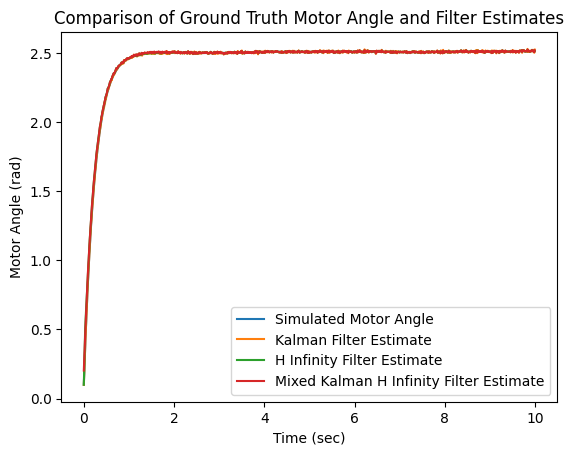

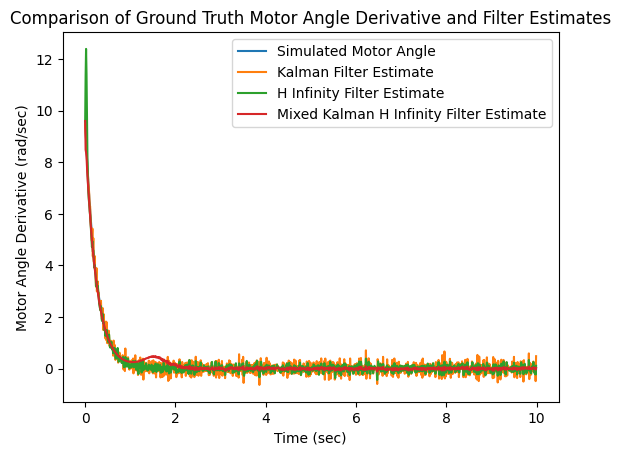

In [13]:
motor_angle_ylabel = 'Motor Angle (rad)'
motor_angle_title = 'Comparison of Ground Truth Motor Angle and Filter Estimates'
plot_filter_data(sim_time, simulated_state[:, 0], kf_estimate[:, 0], h_inf_estimate[:, 0], mixed_kalman_h_inf_estimate[:, 0], motor_angle_title, motor_angle_ylabel)

motor_angle_speed_ylabel = 'Motor Angle Derivative (rad/sec)'
motor_angle_speed_title = 'Comparison of Ground Truth Motor Angle Derivative and Filter Estimates'
plot_filter_data(sim_time, simulated_state[:, 1], kf_estimate[:, 1], h_inf_estimate[:, 1], mixed_kalman_h_inf_estimate[:, 1], motor_angle_speed_title, motor_angle_speed_ylabel)

For the motor angle, with the current axes, all the filters have similar performance and are quite similar to simulated data. 

For the motor angle derivative, the H infinity estimate is less noisy than the Kalman filter in steady state. The mixed Kalman H infinity filter is even smoother than other two filters but it does have a small bump around 1.5 sec.

It will be easier to see the differences if we plot the error between the ground truth and the filter estimates as below.

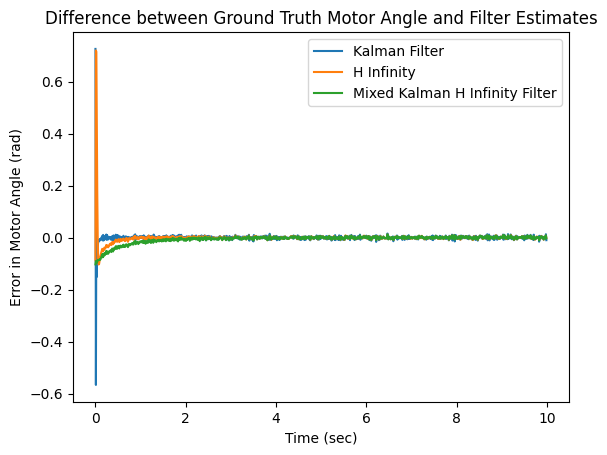

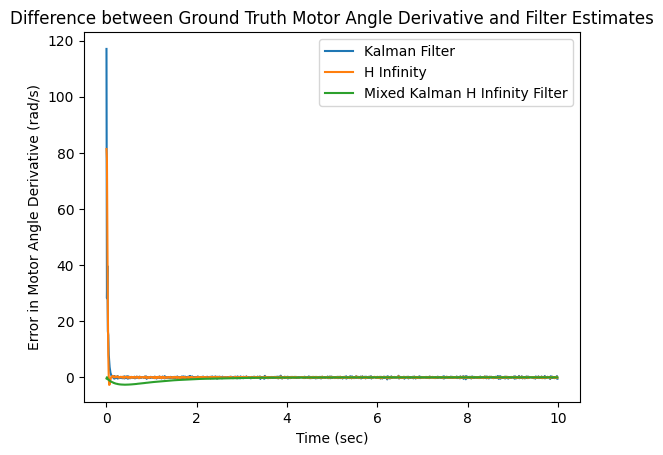

In [19]:
def get_error(ground_truth, estimate):
    angle = [(x - xhat)[0] for (x, xhat) in  zip(ground_truth, estimate)]
    angle_derivative = [(x - xhat)[1] for (x, xhat) in  zip(ground_truth, estimate)]
    return angle, angle_derivative

def plot_error(time, kalman_filter_error, h_inf_filter_error, kalman_h_inf_filter_error, title, ylabel):
    plt.figure()
    plt.plot(time, kalman_filter_error, label='Kalman Filter')
    plt.plot(time, h_inf_filter_error, label='H Infinity')
    plt.plot(time, kalman_h_inf_filter_error, label='Mixed Kalman H Infinity Filter')
    plt.xlabel('Time (sec)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

kalman_filter_error_angle,  kalman_filter_error_angle_derivative = get_error(simulated_state, kf_estimate)
h_inf_filter_error_angle,  h_inf_filter_error_angle_derivative = get_error(simulated_state, h_inf_estimate)
kalman_h_inf_filter_error_angle,  kalman_h_inf_filter_error_angle_derivative = get_error(simulated_state, mixed_kalman_h_inf_estimate)

ylabel = 'Error in Motor Angle (rad)'
title = 'Difference between Ground Truth Motor Angle and Filter Estimates'
plot_error(sim_time, kalman_filter_error_angle, h_inf_filter_error_angle, kalman_h_inf_filter_error_angle, title, ylabel)

ylabel = 'Error in Motor Angle Derivative (rad/s)'
title = 'Difference between Ground Truth Motor Angle Derivative and Filter Estimates'
plot_error(sim_time, kalman_filter_error_angle_derivative, h_inf_filter_error_angle_derivative, kalman_h_inf_filter_error_angle_derivative, title, ylabel)

## Generate Fake Noisy Data with Model Mismatch

Now we can test the robustness of the H infinity filters. We can simulate some model mismatch, purposefully creating a siutation where there's model uncertainty. In this situation, we make reevaluate the state space matrices as though the inertia $J$ is 100 and feed this into the filters. However, we will still use the same ground truth simulation. 

In order words, the filters will think the inertia is much large than the actual inertia, by an order of magnitude. 

In [22]:
# Generate state space matrics assuming a larger inertia than the actual plant
updated_params = {c: 5, J: 100, B: 40}
A_np_increasedJ = np.array(A.subs(updated_params)).astype(np.float64)
B_u_np_increasedJ = np.array(B_u.subs(updated_params)).astype(np.float64)
B_w_np_increasedJ = np.array(B_w.subs(updated_params)).astype(np.float64)
Q_new = B_w_np_increasedJ * (torque_noise_standard_deviation ** 2) * B_w_np_increasedJ.T

A_d_increasedJ = np.identity(2) + timestep * A_np_increasedJ
Bd_u_increasedJ = timestep * B_u_np_increasedJ
Bd_w_increasedJ = timestep * B_w_np_increasedJ

In [23]:
# Kalman filter with model assuming larger inertia
kf_mismatched_J = kalman_filter(F=A_d_increasedJ, G_u=Bd_u_increasedJ, H=H, Q=Q_new, R=R, initial_state=x0, P_initial=Q_new)
kf_estimate = np.zeros(len(sim_time))

# H Infinity Filter with model assuming larger inertia
L = 0.001 * np.identity(2)
S = 1e-4 * np.identity(2)
h_inf_mismatch = h_infinity_filter(F=A_d_increasedJ, G=Bd_u_increasedJ, Q=Q_new, R=R, H=H, initial_state=x0, P_initial=Q, L=L, S=S, theta=0.6)

# Mixed Kalman H Infinity Filter with model assuming larger inertia
P_initial=1e4*np.identity(2)
N = 0.00001*np.identity(2)
epsilon = 1e-8
M1k = np.identity(2)
M2k = np.array([[0, 0]])
L = 0.001 * np.identity(2)
mixed_filter = mixed_kalman_h_infinity_filter(F=A_d_increasedJ, Gd_w = Bd_w_increasedJ, Q=Q_new, R=R, H=H, initial_state=x0, P_initial=P_initial, N=N, epsilon=epsilon, alpha=0.1, M1k=M1k, M2k=M2k, theta=theta, L=L)

# Set up arrays to collect data for plotting 
kf_estimate = np.zeros((len(sim_time),2))
h_inf_estimate = np.zeros((len(sim_time),2))
mixed_kalman_h_inf_estimate = np.zeros((len(sim_time), 2))

# Simulate control input as 0
control_input = 0

# Simulate the filter
for i in range(len(sim_time)):
    kf_estimate[i, :] = kf.run(control_input, raw_measurements[i]).T

    h_inf_estimate[i, :] = h_inf.run(raw_measurements[i]).T

    mixed_kalman_h_inf_estimate[i, :] = mixed_filter.run(np.array([[raw_measurements[i]]])).T

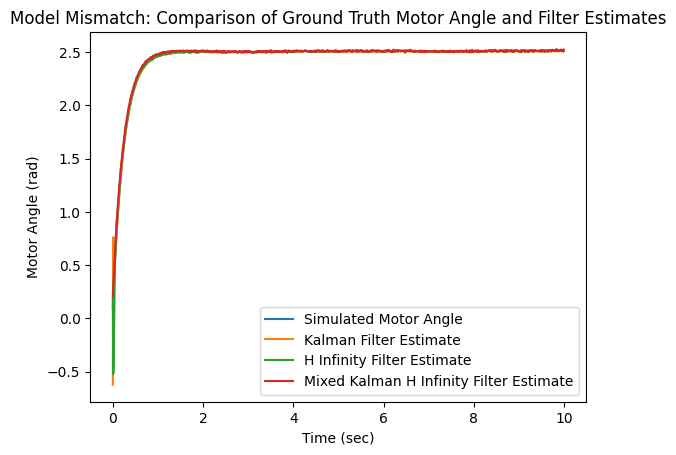

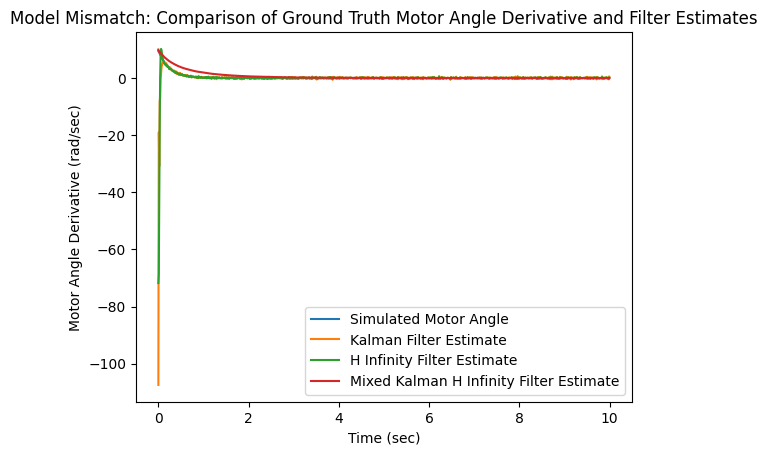

In [24]:
mismatch_motor_angle_title = 'Model Mismatch: Comparison of Ground Truth Motor Angle and Filter Estimates'
plot_filter_data(sim_time, simulated_state[:, 0], kf_estimate[:, 0], h_inf_estimate[:, 0], mixed_kalman_h_inf_estimate[:, 0], mismatch_motor_angle_title, motor_angle_ylabel)

mismatch_motor_angle_speed_title = 'Model Mismatch: Comparison of Ground Truth Motor Angle Derivative and Filter Estimates'
plot_filter_data(sim_time, simulated_state[:, 1], kf_estimate[:, 1], h_inf_estimate[:, 1], mixed_kalman_h_inf_estimate[:, 1], mismatch_motor_angle_speed_title, motor_angle_speed_ylabel)

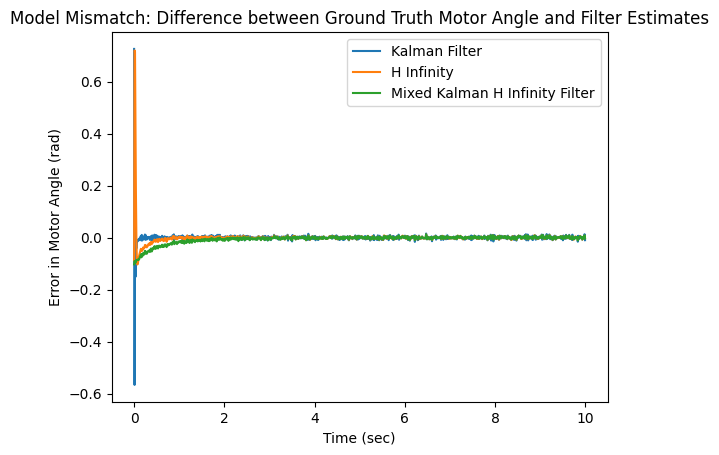

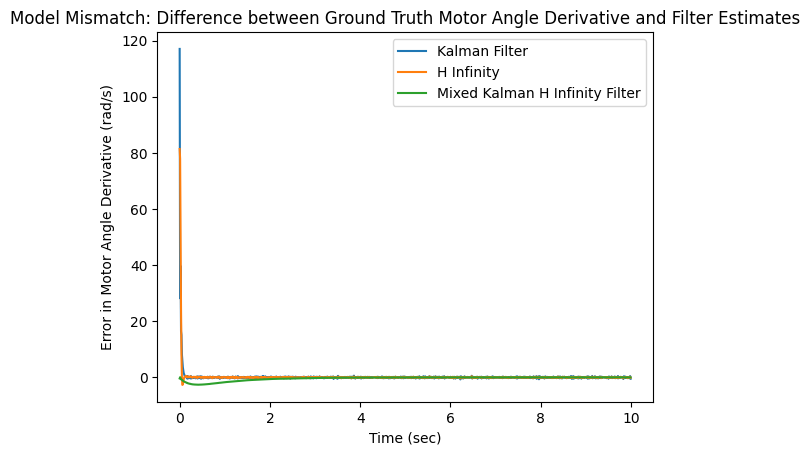

In [25]:
kalman_filter_error_angle,  kalman_filter_error_angle_derivative = get_error(simulated_state, kf_estimate)
h_inf_filter_error_angle,  h_inf_filter_error_angle_derivative = get_error(simulated_state, h_inf_estimate)
kalman_h_inf_filter_error_angle,  kalman_h_inf_filter_error_angle_derivative = get_error(simulated_state, mixed_kalman_h_inf_estimate)

ylabel = 'Error in Motor Angle (rad)'
title = 'Model Mismatch: Difference between Ground Truth Motor Angle and Filter Estimates'
plot_error(sim_time, kalman_filter_error_angle, h_inf_filter_error_angle, kalman_h_inf_filter_error_angle, title, ylabel)

ylabel = 'Error in Motor Angle Derivative (rad/s)'
title = 'Model Mismatch: Difference between Ground Truth Motor Angle Derivative and Filter Estimates'
plot_error(sim_time, kalman_filter_error_angle_derivative, h_inf_filter_error_angle_derivative, kalman_h_inf_filter_error_angle_derivative, title, ylabel)

The filters have the most error in the beginning of the simulation. However, eventually the error of all the filters converges close to 0.

As expected, the Kalman filter performs the worst and the other two filters are better able to handle the uncertainty in the inertia. The mixed Kalman H $\infty$ performs the best and has quite low error given that it was constructed with a inertia mismatched from the true model.

Overall, I think the mixed Kalman H $\infty$ and H $\infty$ are promising filters. I hope to apply them in practice someday!

## Sources

1. *Optimal Estimation* by Dan Simon
2. [Dan Simon's Overiew of State Estimation](https://academic.csuohio.edu/simon-daniel/state-estimation/) *Note this contains the MATLAB files for the examples in his book and the errata*